In [1]:
import os
import random
import tensorflow as tf
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
    ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile


from sklearn.metrics import classification_report, confusion_matrix

MODEL_DIR = './models'
LOG_DIR = './logs'


SIZE = 150, 150

In [2]:
def walk(dir_name):
    names = []
    for dirpath, dirnames, filenames in os.walk(dir_name):
        for filename in filenames:
            names.append(os.path.join(dirpath, filename))
    return names

def image_array(filenames, size):
    result = []
    for filename in filenames:
        image = Image.open(filename)
        image = image.resize(SIZE, Image.ANTIALIAS)
        image_array = np.asarray(image).astype('float32')
        image_array = image_array[:, :, :] / 255
        del image
        result.append(image_array)
    return result


## CallBacks

In [3]:
tensorboard_logs = TensorBoard(log_dir=LOG_DIR, histogram_freq=1,
                               write_graph=False, write_images=True,
                               write_grads=True,
                               update_freq='epoch')
mcp_save = ModelCheckpoint(os.path.join(MODEL_DIR, 
                                        'modelweights.{epoch:02d}-{val_loss:.2f}.hdf5'),
                           save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2,
                              verbose=1, min_delta=1e-2, mode='min')


In [4]:
caminho_bases = os.path.join('bases', 'vazios')
caminho_train = os.path.join(caminho_bases, 'train')
caminho_test = os.path.join(caminho_bases, 'test')

def make_dirs(lista):
    for caminho in lista:
        print(caminho)
        if not os.path.exists(caminho):
            os.mkdir(caminho)
make_dirs([caminho_train, caminho_test])
for classe in ['vazio', 'nvazio']:
    make_dirs([os.path.join(caminho_train, classe),
                os.path.join(caminho_test, classe)])

bases/vazios/train
bases/vazios/test
bases/vazios/train/vazio
bases/vazios/test/vazio
bases/vazios/train/nvazio
bases/vazios/test/nvazio


In [5]:
def split_data(source, train, test, SPLIT_SIZE=.9):
    files = []
    for filename in os.listdir(source):
        file = os.path.join(source, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = os.path.join(source, filename)
        destination = os.path.join(train, filename)
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = os.path.join(source, filename)
        destination = os.path.join(test, filename)
        copyfile(this_file, destination)


VAZIO_SOURCE_DIR = os.path.join(caminho_bases, 'vazio')
TRAIN_VAZIO_DIR = os.path.join(caminho_train, 'vazio')
TEST_VAZIO_DIR = os.path.join(caminho_test, 'vazio')
NVAZIO_SOURCE_DIR = os.path.join(caminho_bases, 'nvazio')
TRAIN_NVAZIO_DIR = os.path.join(caminho_train, 'nvazio')
TEST_NVAZIO_DIR = os.path.join(caminho_test, 'nvazio')

In [6]:
# split_data(VAZIO_SOURCE_DIR, TRAIN_VAZIO_DIR, TEST_VAZIO_DIR)
# split_data(NVAZIO_SOURCE_DIR, TRAIN_NVAZIO_DIR, TEST_NVAZIO_DIR)

In [7]:
for split in os.listdir(caminho_bases):
    caminho_split = os.path.join(caminho_bases, split)
    if os.path.isdir(caminho_split):
        for categoria in os.listdir(caminho_split):
            caminho_total = os.path.join(caminho_bases, split, categoria)
            if os.path.isdir(caminho_total):
                print(split, categoria, len(os.listdir(caminho_total)))


train nvazio 9063
train vazio 10502
test nvazio 1000
test vazio 1000


(513, 122)


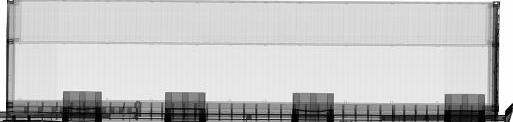

In [8]:
from PIL import Image
from random import sample
SAMPLE_VAZIO = sample(os.listdir(TRAIN_VAZIO_DIR), 1)[0]
img_vazio = Image.open(os.path.join(TRAIN_VAZIO_DIR, SAMPLE_VAZIO))
print(img_vazio.size)
img_vazio

(458, 246)


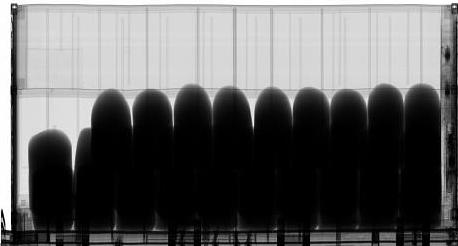

In [9]:
from PIL import Image
from random import sample
SAMPLE_NVAZIO = sample(os.listdir(TRAIN_NVAZIO_DIR), 1)[0]
img_nvazio = Image.open(os.path.join(TRAIN_NVAZIO_DIR, SAMPLE_NVAZIO))
print(img_nvazio.size)
img_nvazio

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    horizontal_flip=True,
)
train_generator = train_datagen.flow_from_directory(
    caminho_train,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    horizontal_flip=True,
)

validation_generator = train_datagen.flow_from_directory(
    caminho_test,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)

Found 19565 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [30]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(32, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), activation='relu'),
  Conv2D(128, (1, 1), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(256, (3, 3), activation='relu'),
  Conv2D(512, (1, 1), activation='relu'),
  Flatten(),
  Dense(512, activation='relu'),
  Dropout(0.2),
  Dense(1, activation='sigmoid')
 
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 34, 34, 64)       

In [32]:
history = model.fit_generator(train_generator,
                              epochs=20,
                              verbose=1,
                              callbacks=[early_stop, mcp_save, reduce_lr, tensorboard_logs],
                              validation_data=validation_generator)

W0521 11:22:15.351036 140634507245312 callbacks.py:1443] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


Epoch 1/20
282/282 [==============================] - 79s 281ms/step - loss: 0.2836 - acc: 0.9409 - val_loss: 0.5045 - val_acc: 0.5000
Epoch 2/20
282/282 [==============================] - 80s 282ms/step - loss: 0.0504 - acc: 0.9836 - val_loss: 0.1144 - val_acc: 0.9650
Epoch 3/20
282/282 [==============================] - 73s 260ms/step - loss: 0.2673 - acc: 0.9844 - val_loss: 0.3107 - val_acc: 0.9965
Epoch 4/20
282/282 [==============================] - 67s 238ms/step - loss: 0.0696 - acc: 0.9897 - val_loss: 0.0731 - val_acc: 0.9835
Epoch 5/20
282/282 [==============================] - 63s 223ms/step - loss: 0.0204 - acc: 0.9949 - val_loss: 0.0194 - val_acc: 0.9920
Epoch 6/20
282/282 [==============================] - 62s 221ms/step - loss: 0.2458 - acc: 0.9922 - val_loss: 0.0477 - val_acc: 0.9840
Epoch 7/20
282/282 [==============================] - 62s 220ms/step - loss: 0.0331 - acc: 0.9940 - val_loss: 0.0669 - val_acc: 0.9760


In [14]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(256, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(256, (3, 3), activation='relu'),
  Dropout(0.25),
  GlobalAveragePooling2D(),
  Dense(256, activation='relu'),
  Dropout(0.2),
  Dense(1, activation='sigmoid')
 
])

model2.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)      

In [19]:
epoch = 0
val_loss = 0
model2.load_weights(
    os.path.join(MODEL_DIR,
                 'model2weights.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
                ))

OSError: Unable to open file (unable to open file: name = './models/model2weights.00-0.00.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [20]:
mcp_save2 = ModelCheckpoint(
    os.path.join(MODEL_DIR, 'model2weights.{epoch:02d}-{val_loss:.2f}.hdf5'),
    save_best_only=True, monitor='val_loss', mode='min'
)

history = model2.fit_generator(train_generator,
                               initial_epoch=epoch,
                              epochs=30,
                              verbose=1,
                              callbacks=[early_stop, mcp_save2, reduce_lr, tensorboard_logs],
                              validation_data=validation_generator)

Epoch 1/30
306/306 [==============================] - 145s 474ms/step - loss: 0.1800 - acc: 0.9454 - val_loss: 0.3843 - val_acc: 0.9125
Epoch 2/30
306/306 [==============================] - 131s 430ms/step - loss: 0.1837 - acc: 0.9769 - val_loss: 0.0672 - val_acc: 0.9790
Epoch 3/30
306/306 [==============================] - 133s 435ms/step - loss: 0.0942 - acc: 0.9773 - val_loss: 0.0475 - val_acc: 0.9845
Epoch 4/30
306/306 [==============================] - 141s 461ms/step - loss: 0.1320 - acc: 0.9837 - val_loss: 0.0882 - val_acc: 0.9685
Epoch 5/30
306/306 [==============================] - 133s 435ms/step - loss: 0.0408 - acc: 0.9896 - val_loss: 0.0161 - val_acc: 0.9965
Epoch 6/30
306/306 [==============================] - 137s 447ms/step - loss: 0.2033 - acc: 0.9849 - val_loss: 0.0331 - val_acc: 0.9895
Epoch 7/30
305/306 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9910
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
306/306 [===

<Figure size 432x288 with 0 Axes>

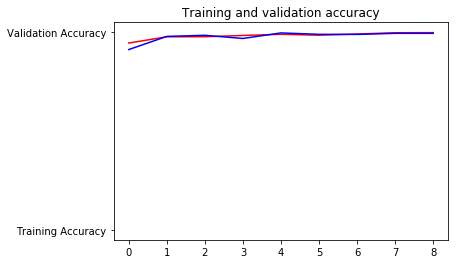

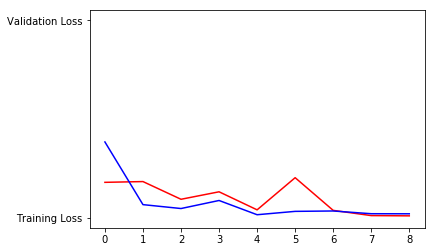

<Figure size 432x288 with 0 Axes>

In [21]:
%matplotlib inline
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


In [22]:
y_test = []
y_pred = []
for r in range(len(validation_generator)):
    X, y = next(validation_generator)
    y_test.extend(y)
    y_pred_ = model2.predict_on_batch(X)
    for y_ in y_pred_:
        if y_ > 0.5:
            y_pred.append(1.)
        else:
            y_pred.append(0.)

In [23]:
print(len(y_test))

2000


In [24]:
print(len(y_pred))

2000


In [25]:
confusion_matrix(y_test, y_pred)

array([[ 987,   13],
       [   0, 1000]])

In [26]:
X_error = []
y_train = []
y_pred_train = []
for r in range(len(train_generator)):
    X, y = next(train_generator)
    y_train.extend(y)
    y_pred_train_ = model2.predict_on_batch(X)
    for ind, (y_, y_true) in enumerate(zip(y_pred_train_, y)):
        if y_ > 0.5:
            y__ = 1.
        else:
            y__ = 0.
        y_pred_train.append(y__)
        if y__ != y_true:
            X_error.append(X[ind])


In [27]:
confusion_matrix(y_train, y_pred_train)

array([[ 8979,    84],
       [    0, 10502]])

In [28]:
np.nonzero(np.array(y_train) != np.array(y_pred_train))

(array([   95,   145,   213,   596,  1392,  1678,  1680,  1720,  1772,
         2058,  2639,  2684,  2976,  3104,  3189,  3304,  3307,  3424,
         3544,  3551,  3863,  3944,  4446,  4870,  4922,  5270,  5324,
         5781,  5812,  6181,  7341,  7477,  7635,  7649,  7681,  7738,
         7972,  8005,  8018,  8051,  8267,  8505,  8507,  8586,  8828,
         8848,  9002,  9229,  9247, 10063, 10171, 10665, 10818, 11152,
        11421, 11497, 11533, 11556, 12202, 12256, 12677, 12870, 13765,
        14389, 14409, 14625, 14988, 15892, 16008, 16190, 16544, 16579,
        16821, 16840, 16958, 17711, 18449, 18557, 18841, 18853, 19328,
        19416, 19496, 19508]),)

In [29]:
len(X_error)

84

0.0 1.0


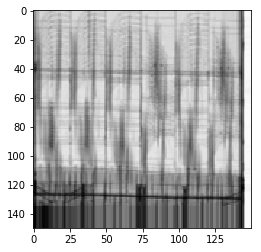

In [30]:
print(y_train[95], y_pred_train[95])
plt.imshow(X_error[0])

0.0 1.0


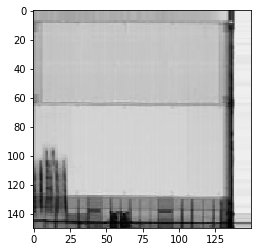

In [32]:
print(y_train[213], y_pred_train[213])
plt.imshow(X_error[2])

0.0 1.0


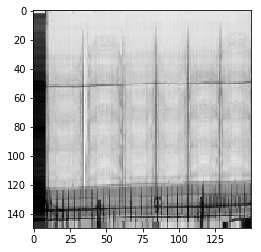

In [33]:
print(y_train[596], y_pred_train[596])
plt.imshow(X_error[3])

In [35]:
activation_model = tf.keras.Model(inputs=model2.input,
                                  outputs=model2.get_layer('global_average_pooling2d_1').output)

(256,)


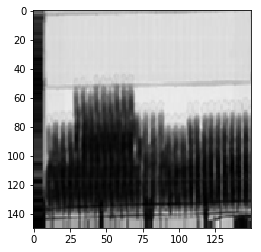

In [36]:
test_image, _ = next(train_generator)
activations = activation_model.predict(np.expand_dims(test_image[0], axis =0))
print(activations[0].shape)
plt.imshow(test_image[0])

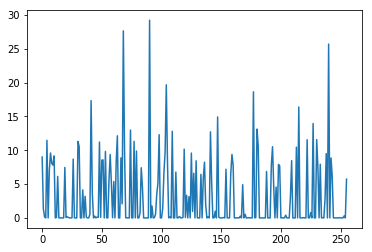

In [37]:
plt.plot(activations[0])

In [38]:
def show_activations(layer_name, image):
    activation_model = tf.keras.Model(inputs=model2.input,
                                  outputs=model2.get_layer(layer_name).output)
    activations = activation_model.predict(np.expand_dims(image, axis=0))
    rows = cols = int(activations[0].shape[2] ** 0.5)
    print(rows, cols)
    fig, axes = plt.subplots(rows, cols, figsize=(10,10))
    for r in range(rows * cols):
        axes[r % rows, r // cols].imshow(activations[0][:, :, r])

8 8


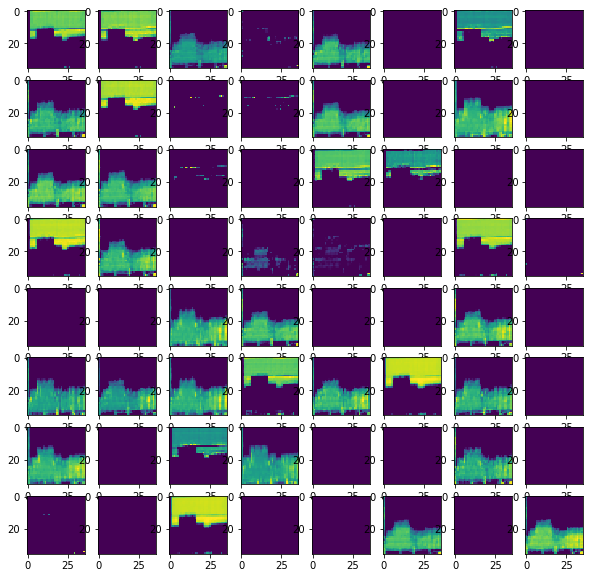

In [39]:
show_activations('max_pooling2d_5', test_image[0])

16 16


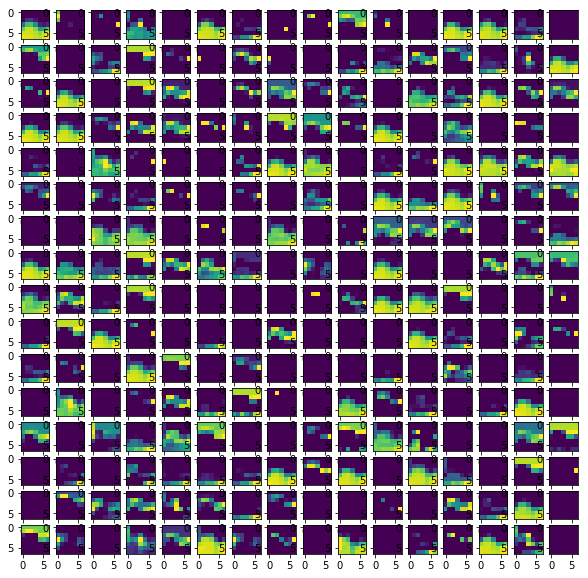

In [40]:
show_activations('max_pooling2d_7', test_image[0])

11 11


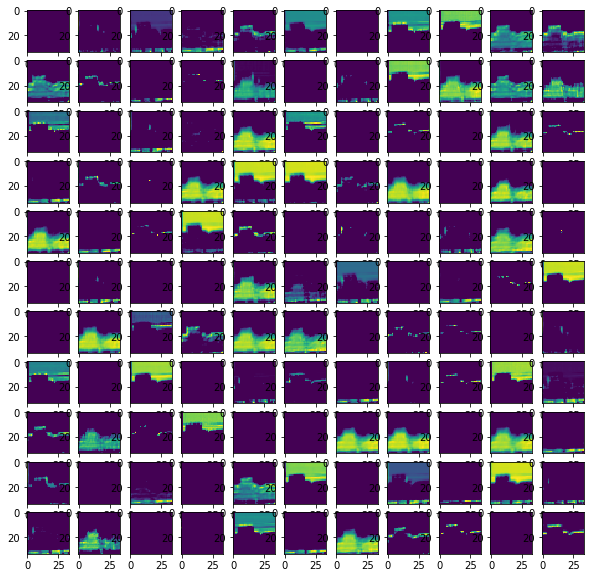

In [42]:
show_activations('conv2d_7', test_image[0])

In [44]:
vazios_dificeis = walk('bases/vazios_teste/vaziosdificeis_depurado/')
naovazios_dificeis = walk('bases/vazios_teste/naovaziosdificeis_depurado/')

In [61]:
X_error = []
y_true = np.zeros(1000)
y_pred_train = np.zeros(1000)
X = np.vstack([image_array(naovazios_dificeis[:1000], SIZE)])
y_pred_train_ = model2.predict_on_batch(X)
for ind, y_ in enumerate(y_pred_train_):
    if y_ > 0.5:
        y__ = 1.
    else:
        y__ = 0.
    y_pred_train[ind] = y__
    if y__ == 0.:
        X_error.append(X[ind])



In [62]:
len(X_error)

268

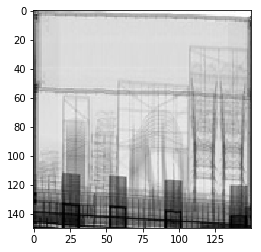

In [63]:
plt.imshow(X_error[12])

In [64]:
X_error = []
y_true = np.zeros(1000)
y_pred_train = np.zeros(1000)
X = np.vstack([image_array(vazios_dificeis[:1000], SIZE)])
y_pred_train_ = model2.predict_on_batch(X)
for ind, y_ in enumerate(y_pred_train_):
    if y_ > 0.5:
        y__ = 1.
    else:
        y__ = 0.
    y_pred_train[ind] = y__
    if y__ == 1.:
        X_error.append(X[ind])


In [65]:
len(X_error)

1000

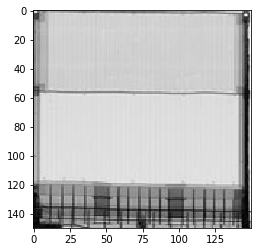

In [68]:
plt.imshow(X_error[10])